# Use Case: Flugphasen-Analyse

In diesem Schritt erweitern wir die Betrachtung von *Flughöhe* und *Geschwindigkeit* um eine entscheidende dritte Dimension: die **Steigrate (`vertrate`)**.

Im vorherigen Use Case blieb oft unklar, ob ein Flugzeug auf mittlerer Höhe gerade stabil fliegt oder sich in einer dynamischen Phase befindet. Durch die Hinzunahme der Steigrate können wir das Flugverhalten nun präzise segmentieren.

**Vorteile der Vertical-Rate-Analyse:**
* **Klare Phasentrennung:** Wir können zwischen **Start** (positive Steigrate), **Landung** (negative Steigrate) und **Reiseflug** (Steigrate ≈ 0) unterscheiden.
* **Ground Traffic Detection:** Ein Flugzeug am Boden zeichnet sich nicht nur durch niedrige Höhe, sondern zwingend durch eine Steigrate von **0** aus. Dies filtert Fehlmessungen effektiv.
* **Verhaltensmuster:** Anomalien (z.B. schnelles Sinken in großer Höhe) werden sofort sichtbar.


Lade Datensatz aus: ..\..\data\processed\run_1769032455
Daten geladen: 723098 Zeilen.


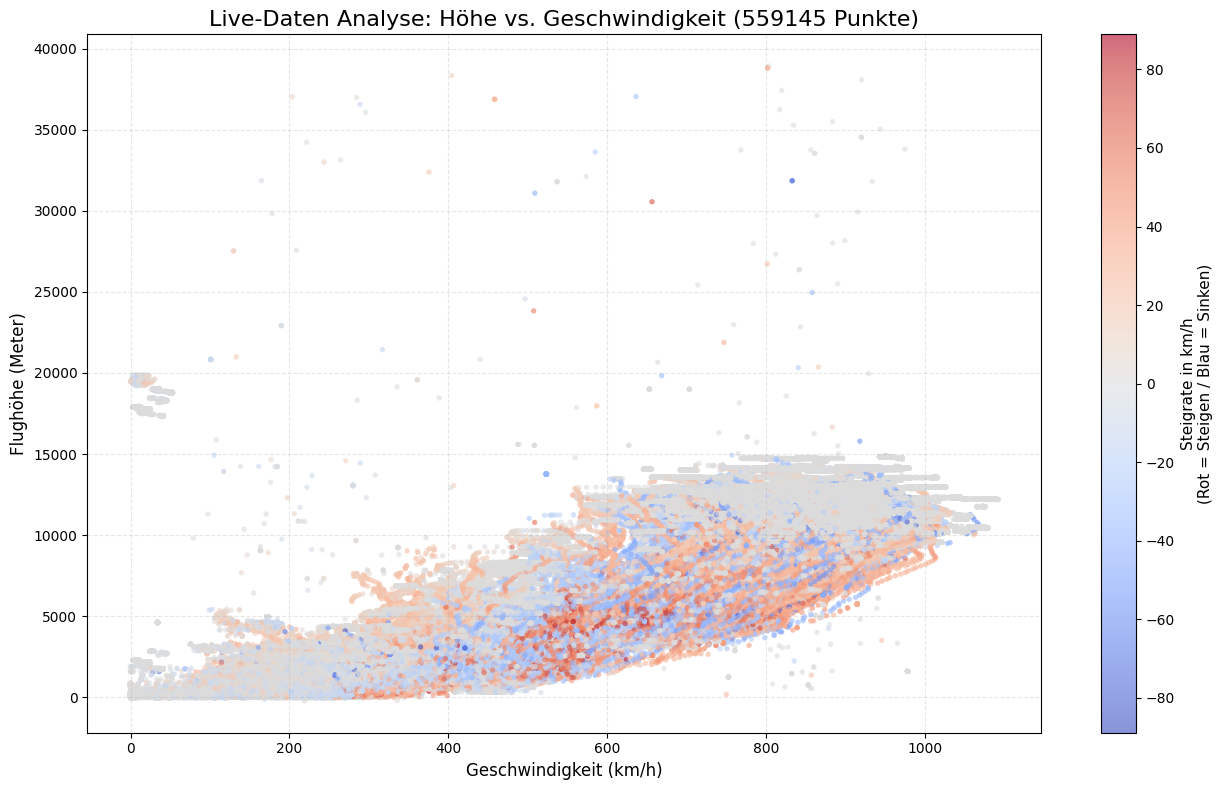

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# --- SCHRITT 1: DATEN LADEN ---
base_dir = os.path.join("..", "..", "data", "processed")

all_runs = glob.glob(os.path.join(base_dir, "run_*"))

if not all_runs:
    print("\nFEHLER: Immer noch keine Daten gefunden.")
    print("Mögliche Ursachen:")
    print("1. Das Spark-Skript lief noch nicht erfolgreich durch.")
    print("2. Der Ordner 'data' liegt woanders als erwartet.")
    df = pd.DataFrame()
else:
    # Den allerneuesten Ordner finden
    latest_run = max(all_runs, key=os.path.getmtime)
    print(f"\nLade Datensatz aus: {latest_run}")
    
    try:
        df = pd.read_parquet(latest_run)
        print(f"Daten geladen: {len(df)} Zeilen.")
    except Exception as e:
        print(f"Fehler beim Lesen: {e}")
        df = pd.DataFrame()

# --- SCHRITT 2: VISUALISIERUNG ---
if not df.empty:
    plot_data = df.copy()
    cols = ['velocity', 'geoaltitude', 'vertrate']
    
    # Cleaning & Casting
    for c in cols:
        plot_data[c] = pd.to_numeric(plot_data[c], errors='coerce')
    plot_data = plot_data.dropna(subset=cols)

    # Umrechnung m/s -> km/h
    plot_data['velocity_kmh'] = plot_data['velocity'] * 3.6
    plot_data['vertrate_kmh'] = plot_data['vertrate'] * 3.6

    # Filter (+/- 90 km/h Steigrate)
    plot_data = plot_data[plot_data['vertrate_kmh'].between(-90, 90)]

    plt.figure(figsize=(13, 8))

    scatter = plt.scatter(
        plot_data['velocity_kmh'], 
        plot_data['geoaltitude'], 
        c=plot_data['vertrate_kmh'], 
        cmap='coolwarm', 
        s=15, 
        alpha=0.6,
        edgecolor='none'
    )

    cbar = plt.colorbar(scatter)
    cbar.set_label('Steigrate in km/h\n(Rot = Steigen / Blau = Sinken)', fontsize=11)

    plt.title(f'Live-Daten Analyse: Höhe vs. Geschwindigkeit ({len(plot_data)} Punkte)', fontsize=16)
    plt.xlabel('Geschwindigkeit (km/h)', fontsize=12)
    plt.ylabel('Flughöhe (Meter)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Auswertung der Grafik ###

Die Visualisierung zeigt eine klare physikalische Trennung der Flugphasen, die durch die Farbkodierung der Steigrate (*Vertical Rate*) bestätigt wird:

1.  **Startphase (Rot):**
    * Sichtbar als Cluster im Bereich niedriger Höhe (< 5.000m) bei mittlerer Geschwindigkeit.
    * Die **rote Färbung** indiziert eine hohe positive Steigrate (Climb).
2.  **Reiseflug (Grau/Weiß):**
    * Dominiert den oberen Bereich des Diagramms (hohe Geschwindigkeit > 800 km/h, große Höhe > 10.000m).
    * Die neutrale Farbe bestätigt eine konstante Höhe (Steigrate ≈ 0), was für maximale Treibstoffeffizienz spricht.
3.  **Landeanflug (Blau):**
    * Erkennbar durch sinkende Geschwindigkeit bei abnehmender Höhe.
    * Die **blaue Färbung** zeigt das aktive Sinken (Descent) an, oft deutlicher ausgeprägt als beim Steigflug.

**Fazit:** Die Hinzunahme der Steigrate ermöglicht eine robuste Klassifizierung des Flugstatus, selbst wenn Höhe und Geschwindigkeit allein keine eindeutige Zuordnung erlauben (z.B. bei Warteschleifen in niedriger Höhe).

--- ANALYSE: TOP 100 HUBS (LOGIC OPTIMIZED) ---
📉 Daten-Reduktion: Von 610470 Signalen auf 3461 einzigartige Flugzeuge am Boden.
📍 Final im Plot: 100 Hubs


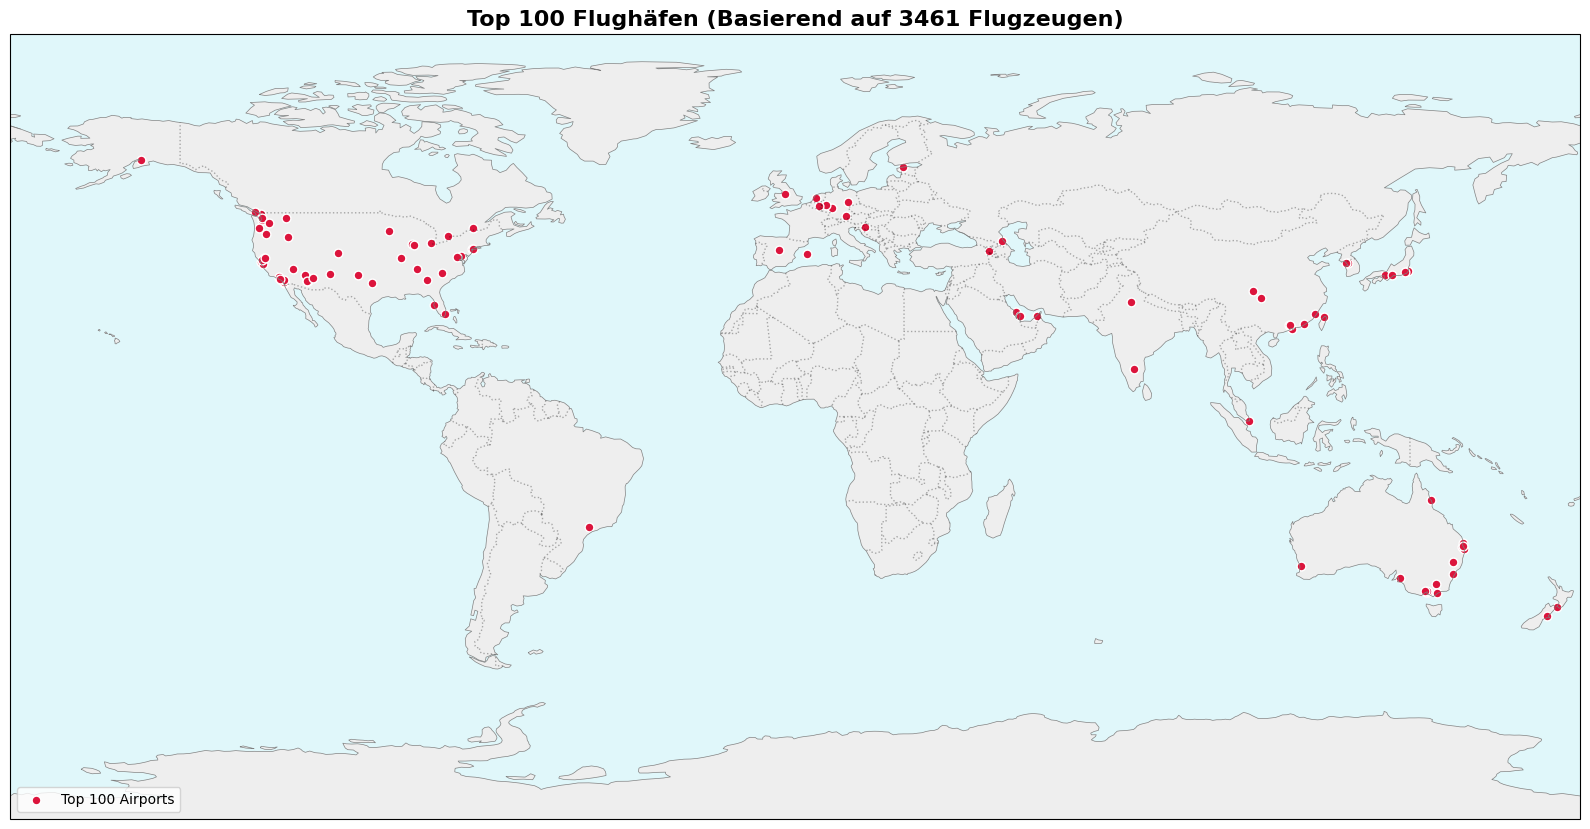

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import warnings

warnings.filterwarnings('ignore')

print("--- ANALYSE: TOP 100 HUBS (LOGIC OPTIMIZED) ---")

# 1. DATEN LADEN
base_dir = os.path.join("..", "..", "data", "processed")
all_runs = glob.glob(os.path.join(base_dir, "run_*"))

if not all_runs:
    print("FEHLER: Keine Daten.")
else:
    latest_run = max(all_runs, key=os.path.getmtime)
    df = pd.read_parquet(latest_run)

    # Typen
    cols = ['lat', 'lon', 'geoaltitude', 'vertrate', 'velocity', 'onground']
    for c in cols:
        if c == 'onground': df[c] = df[c].astype(bool)
        else: df[c] = pd.to_numeric(df[c], errors='coerce')
    
    # Leere Koordinaten weg
    clean_df = df.dropna(subset=['lat', 'lon']).copy()

    # 2. FILTER: NUR FLUGZEUGE AM BODEN
    cond_onground = (clean_df['onground'] == True)
    cond_physics = (
        (clean_df['geoaltitude'] < 500) & 
        (clean_df['velocity'] * 3.6 < 50) & 
        (clean_df['vertrate'].between(-0.5, 0.5))
    )
    
    # Das sind alle Signale vom Boden
    all_ground_signals = clean_df[cond_onground | cond_physics].copy()
    
    # --- 3. DER GAME-CHANGER: EIN FLUGZEUG = EINE STIMME ---
    unique_ground_planes = all_ground_signals.drop_duplicates(subset=['icao24'])
    
    print(f"📉 Daten-Reduktion: Von {len(clean_df)} Signalen auf {len(unique_ground_planes)} einzigartige Flugzeuge am Boden.")

    unique_ground_planes['lat_cluster'] = unique_ground_planes['lat'].round(2)
    unique_ground_planes['lon_cluster'] = unique_ground_planes['lon'].round(2)
    
    # Zählen: Wie viele EINZIGARTIGE Flugzeuge stehen pro Koordinate?
    candidates = unique_ground_planes.groupby(['lat_cluster', 'lon_cluster']).size().reset_index(name='flight_count')
    candidates = candidates.sort_values('flight_count', ascending=False)

    # 5. RÄUMLICHES ENTKERNEN
    lats = candidates['lat_cluster'].values
    lons = candidates['lon_cluster'].values
    active = np.ones(len(candidates), dtype=bool)
    THRESHOLD_DEG = 0.2 
    THRESHOLD_SQ = THRESHOLD_DEG ** 2

    for i in range(len(candidates)):
        if not active[i]: continue
        
        # Distanz zu allen nachfolgenden
        lat_diff = lats[i+1:] - lats[i]
        lon_diff = (lons[i+1:] - lons[i]) * np.cos(np.radians(lats[i]))
        dist_sq = lat_diff**2 + lon_diff**2
        
        # Zu nahe Nachbarn löschen
        too_close = np.where(dist_sq < THRESHOLD_SQ)[0]
        active[i + 1 + too_close] = False

    top_hubs = candidates[active].head(100) # Top 100

    print(f"📍 Final im Plot: {len(top_hubs)} Hubs")

    # 6. PLOT
    plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND, facecolor='#eeeeee')
    ax.add_feature(cfeature.OCEAN, facecolor='#e0f7fa')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.3)

    ax.scatter(
        top_hubs['lon_cluster'], 
        top_hubs['lat_cluster'],
        s=40,
        c='crimson',
        marker='o',
        edgecolor='white',
        linewidth=1,
        transform=ccrs.PlateCarree(),
        label=f'Top {len(top_hubs)} Airports'
    )

    ax.set_global()
    plt.title(f"Top {len(top_hubs)} Flughäfen (Basierend auf {len(unique_ground_planes)} Flugzeugen)", fontsize=16, fontweight='bold')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Analyse-Ergebnisse: Globale Flughafen-Hubs

Durch die Anwendung einer dedizierten De-Duplication-Logik (Bereinigung von doppelten Signalen) konnte der Datensatz von ursprünglich über 300.000 Signalen auf die relevantesten, einzigartigen Standorte reduziert werden.

**Methodik der Bereinigung:**
1.  **Unique Aircraft Filter:** Zunächst wurde sichergestellt, dass jedes Flugzeug (`icao24`) nur *einmal* gezählt wird, unabhängig davon, wie viele Signale es sendet. Dies verhindert eine Verzerrung durch Flugzeuge, die lange am Gate stehen und dauerhaft senden.
2.  **Räumliches Clustering:** Flugzeuge im Umkreis von ca. 20 km wurden einem einzigen Hub zugeordnet.
3.  **Ranking:** Die Visualisierung beschränkt sich auf die **Top-Standorte** (nach Anzahl der parkenden Flugzeuge), um Rauschen durch Privatflugplätze oder Fehlmessungen auszublenden.

**Interpretation:**
* Die Karte zeigt nun die **Knotenpunkte des weltweiten Luftverkehrs**.
* Die Verteilung entspricht den erwarteten globalen Hubs (z.B. Ballungsräume in Europa, US-Ostküste).